In [1]:
import pandas
import pickle 
import torch 

In [2]:
pretrained_ckpt = '../ckpts/Seed_1__Tr_Pedestrian__Val_Pedestrian__ValRatio_0.1__filter_agent_type__train.pt'
lora_ckpt = '../ckpts/DC0__lora/Seed_1__Tr_Biker__Val_Biker__ValRatio_0.1__filter_agent_type_deathCircle_0__lora_1__Pos_0_1_2_3_4__TrN_20__lr_0.0005.pt'
lora = torch.load(lora_ckpt)
pretrained = torch.load(pretrained_ckpt)

In [3]:
import matplotlib.pyplot as plt 
%matplotlib inline 

In [4]:
list_lora_layer = ['encoder.stages.0.0', 'encoder.stages.1.1', 'encoder.stages.1.3', 'encoder.stages.2.1', 'encoder.stages.2.3', 'encoder.stages.3.1', 'encoder.stages.3.3', 'encoder.stages.4.1', 'encoder.stages.4.3']

In [5]:
for i, layer in enumerate(list_lora_layer):
    add = (lora[layer+'.lora_B'] @ lora[layer+'.lora_A']).cpu().detach().numpy()
    print('layer:', layer, ', # total:', add.reshape(-1).shape[0], ', # non-zero:', (add != 0.0).sum(),
        ', % non-zero:', round((add != 0.0).sum() / add.reshape(-1).shape[0], 2))

layer: encoder.stages.0.0 , # total: 4032 , # non-zero: 4032 , % non-zero: 1.0
layer: encoder.stages.1.1 , # total: 9216 , # non-zero: 8352 , % non-zero: 0.91
layer: encoder.stages.1.3 , # total: 9216 , # non-zero: 8640 , % non-zero: 0.94
layer: encoder.stages.2.1 , # total: 18432 , # non-zero: 17568 , % non-zero: 0.95
layer: encoder.stages.2.3 , # total: 36864 , # non-zero: 32256 , % non-zero: 0.88
layer: encoder.stages.3.1 , # total: 36864 , # non-zero: 33984 , % non-zero: 0.92
layer: encoder.stages.3.3 , # total: 36864 , # non-zero: 35712 , % non-zero: 0.97
layer: encoder.stages.4.1 , # total: 36864 , # non-zero: 33408 , % non-zero: 0.91
layer: encoder.stages.4.3 , # total: 36864 , # non-zero: 29376 , % non-zero: 0.8


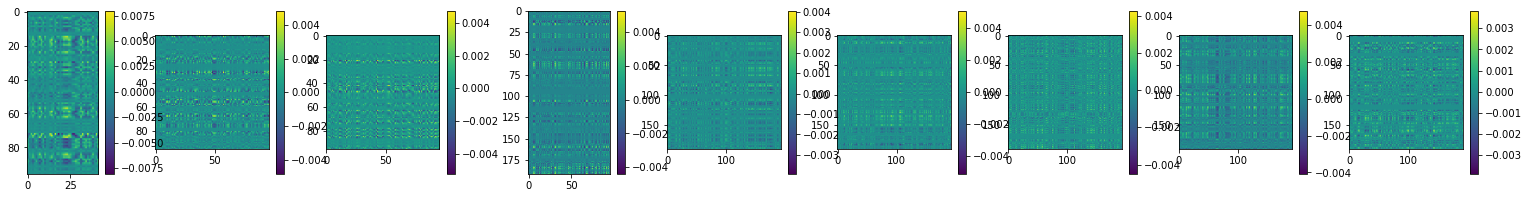

In [8]:
fig, axes = plt.subplots(1, 9, figsize=(27, 3))
for i, layer in enumerate(list_lora_layer):
    add = (lora[layer+'.lora_B'] @ lora[layer+'.lora_A']).cpu().detach().numpy()
    im = axes[i].imshow(add)
    plt.colorbar(im, ax=axes[i])

In [13]:
out_dir = '../figures/lora_weight/'

vmax, vmin = 0, 0
width_ratio = 0
for i, layer in enumerate(list_lora_layer):
    add = (lora[layer+'.lora_B'] @ lora[layer+'.lora_A']).cpu().detach().numpy()
    vmax, vmin = max(vmax, add.max()), min(vmin, add.min())
    width_ratio += add.shape[1] / add.shape[0]

In [14]:
width_ratio

7.9375

In [9]:
# plot one by one 
for i, layer in enumerate(list_lora_layer):
    add = (lora[layer+'.lora_B'] @ lora[layer+'.lora_A']).cpu().detach().numpy()
    plt.figure()
    plt.imshow(add, vmin=vmin, vmax=vmax)
    plt.title(layer)
    plt.colorbar()
    plt.savefig(out_dir+f'{layer}_absolute.png', bbox_inches='tight')
    plt.close()

In [22]:
# plot together 
fig, axes = plt.subplots(1, len(list_lora_layer), figsize=(width_ratio*10, 6))
for i, layer in enumerate(list_lora_layer):
    add = (lora[layer+'.lora_B'] @ lora[layer+'.lora_A']).cpu().detach().numpy()
    im = axes[i].imshow(add, vmin=vmin, vmax=vmax)
    axes[i].set_title(layer)
plt.colorbar(im, ax=axes[:], shrink=0.8)
plt.subplots_adjust(wspace=0.05, hspace=0.02, bottom=0.1, right=0.78, top=0.9)
plt.savefig(out_dir+'All_absolute.png', bbox_inches='tight')
plt.close()

In [28]:
for n, p in pretrained.items():
    if 'encoder.stages' in n and'weight' in n:
        print(n, p.shape)

encoder.stages.0.0.weight torch.Size([32, 14, 3, 3])
encoder.stages.1.1.weight torch.Size([32, 32, 3, 3])
encoder.stages.1.3.weight torch.Size([32, 32, 3, 3])
encoder.stages.2.1.weight torch.Size([64, 32, 3, 3])
encoder.stages.2.3.weight torch.Size([64, 64, 3, 3])
encoder.stages.3.1.weight torch.Size([64, 64, 3, 3])
encoder.stages.3.3.weight torch.Size([64, 64, 3, 3])
encoder.stages.4.1.weight torch.Size([64, 64, 3, 3])
encoder.stages.4.3.weight torch.Size([64, 64, 3, 3])


In [8]:
import numpy as np

In [9]:
# pixel difference
for layer in list_lora_layer:
    add = (lora[layer+'.lora_B'] @ lora[layer+'.lora_A']).cpu().detach().numpy()
    pre = pretrained[layer+'.weight'].cpu().detach().numpy().reshape(add.shape)
    ratio_p = np.abs(add / pre)
    ratio_b = np.abs(add / (pre + add))
    print(layer, add.shape, 'mean_p =', ratio_p.mean(), 'mean_b =', ratio_b.mean())   

encoder.stages.0.0 (96, 42) mean_p = 0.10818621 mean_b = 0.083435036
encoder.stages.1.1 (96, 96) mean_p = 0.07840838 mean_b = 0.10615697
encoder.stages.1.3 (96, 96) mean_p = 0.07414225 mean_b = 0.074727565
encoder.stages.2.1 (192, 96) mean_p = 0.11612172 mean_b = 0.1124526
encoder.stages.2.3 (192, 192) mean_p = 0.23261428 mean_b = 0.117809094
encoder.stages.3.1 (192, 192) mean_p = 0.12636644 mean_b = 0.12013747
encoder.stages.3.3 (192, 192) mean_p = 0.16969472 mean_b = 0.37381533
encoder.stages.4.1 (192, 192) mean_p = 0.2145456 mean_b = 0.202534
encoder.stages.4.3 (192, 192) mean_p = 0.14281355 mean_b = 0.26979163


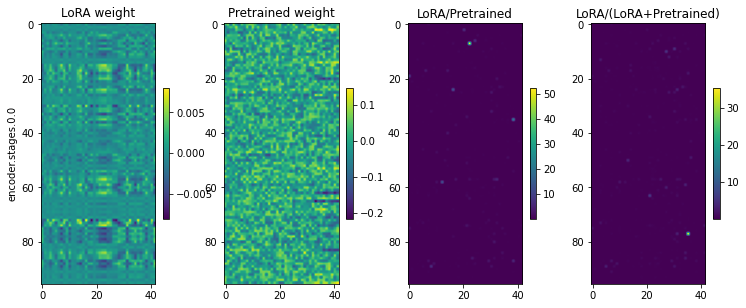

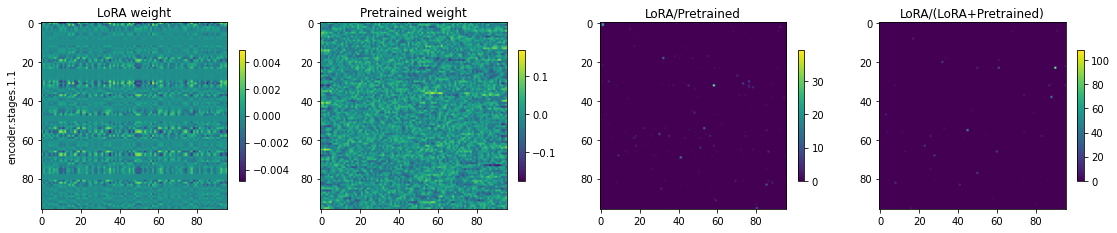

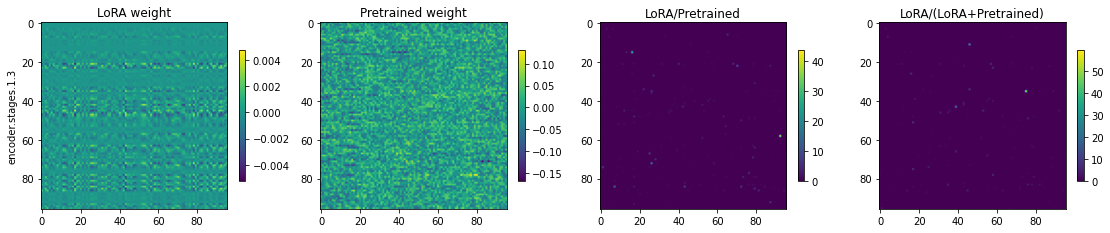

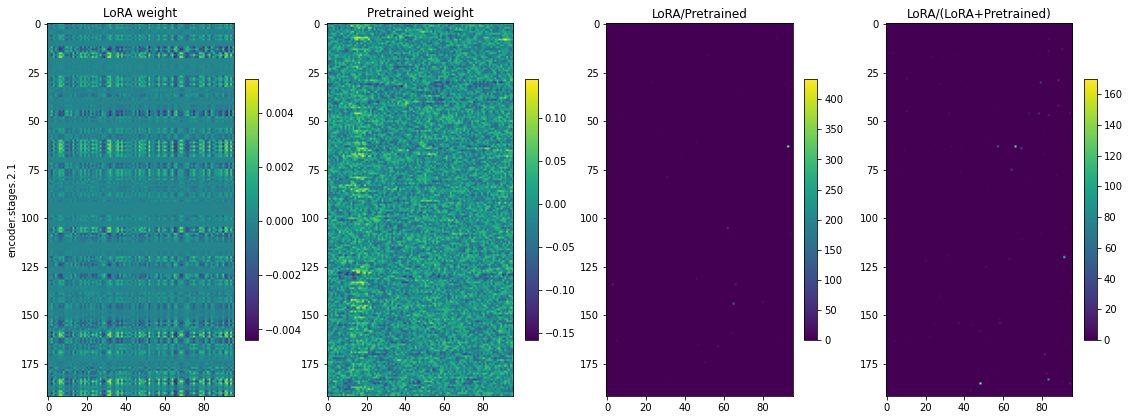

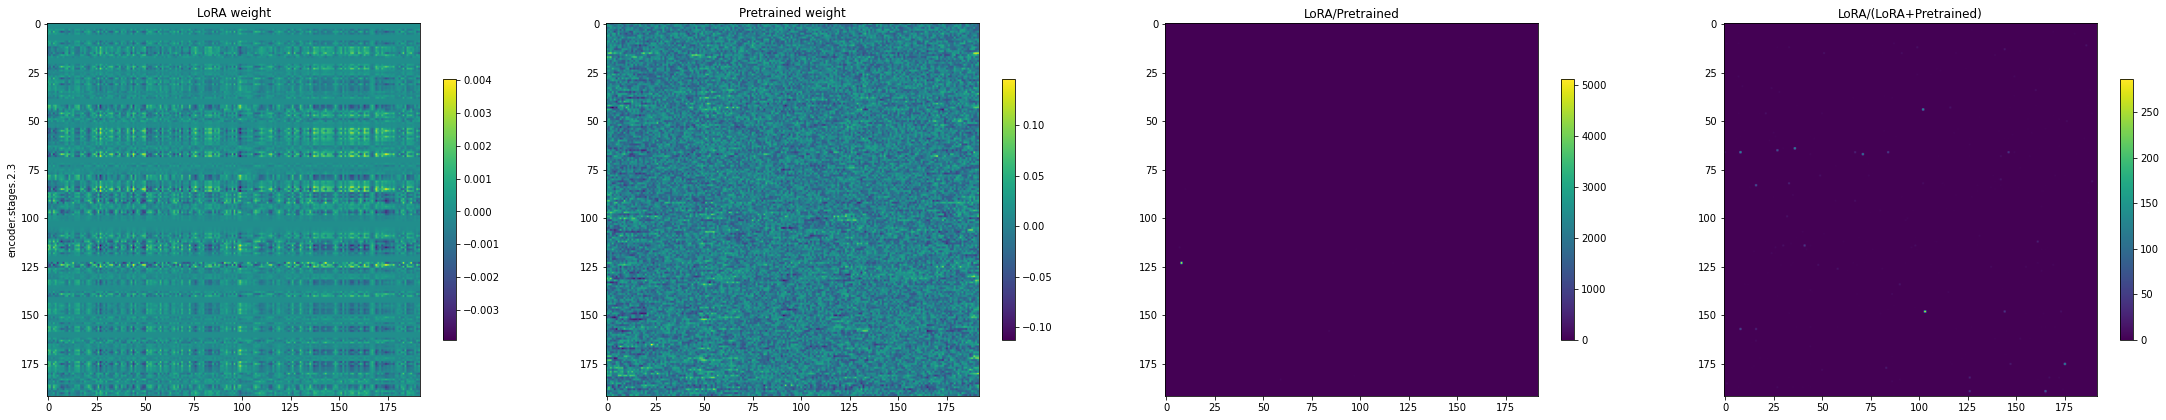

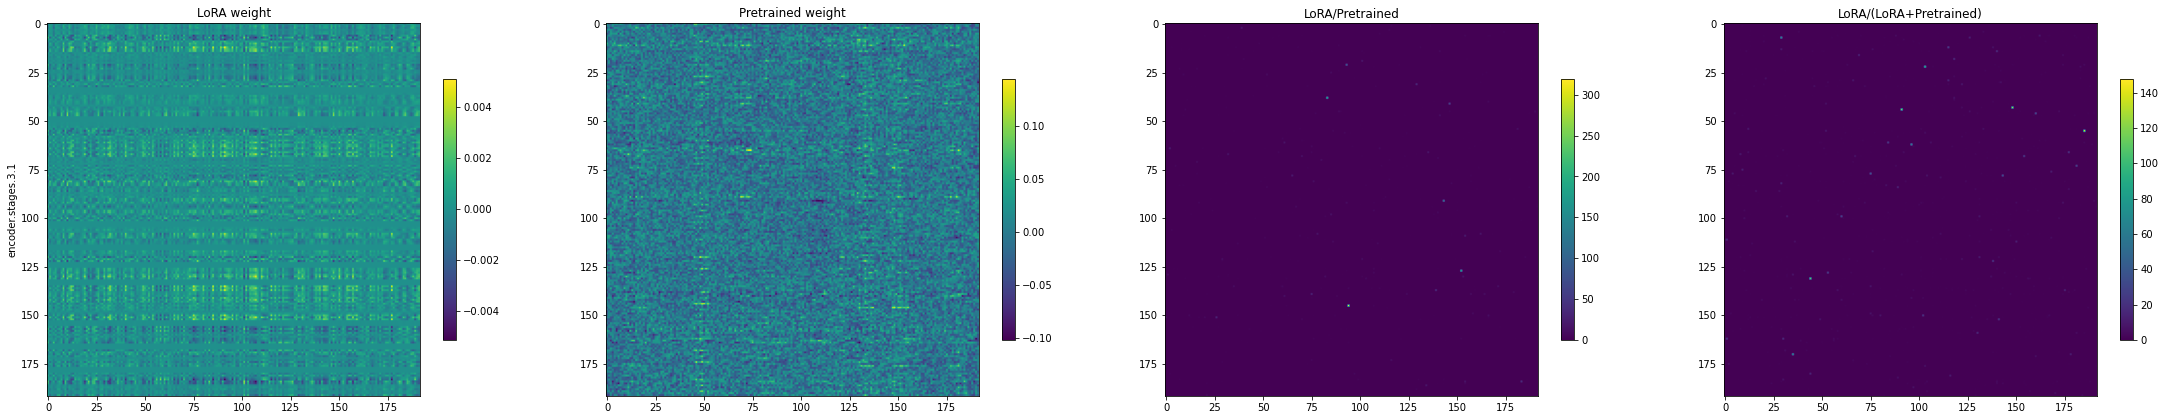

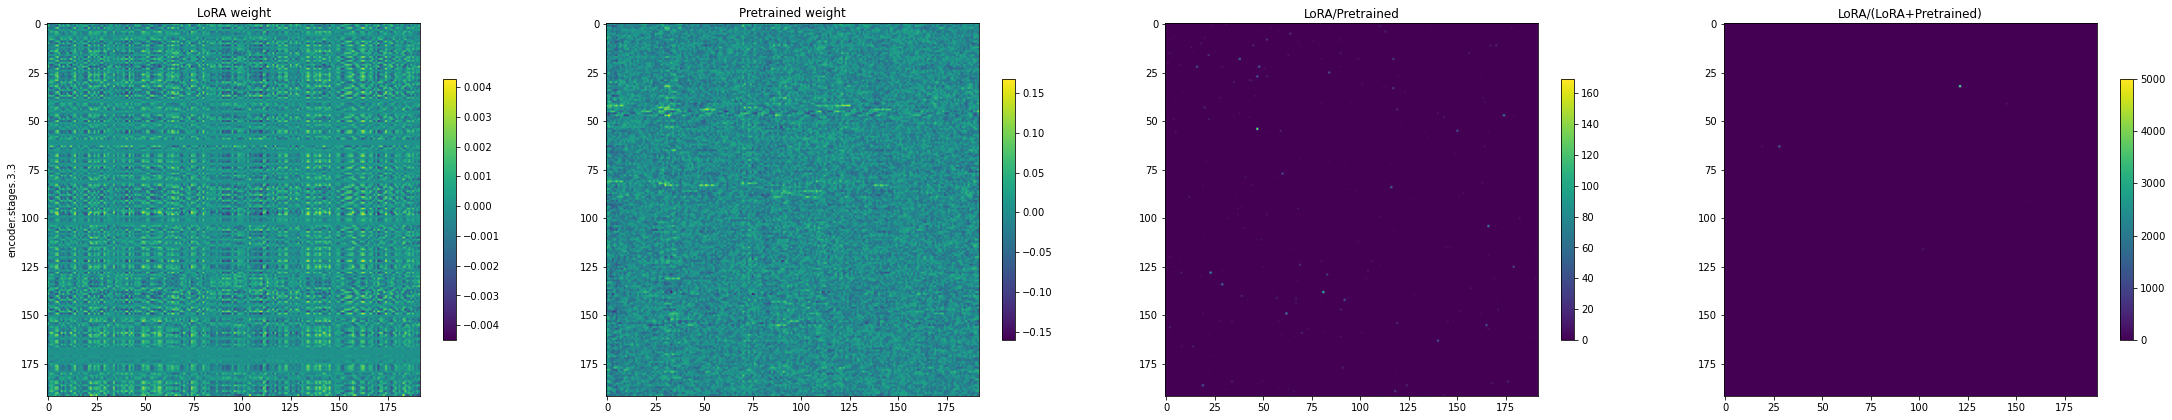

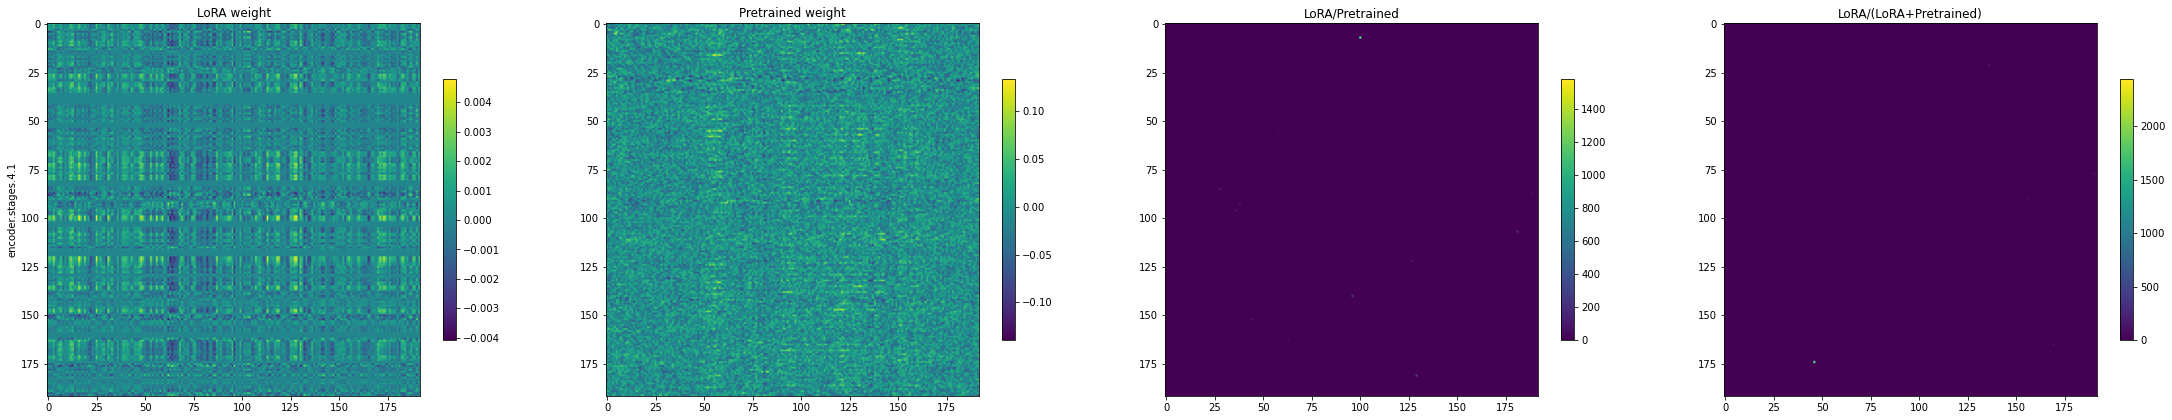

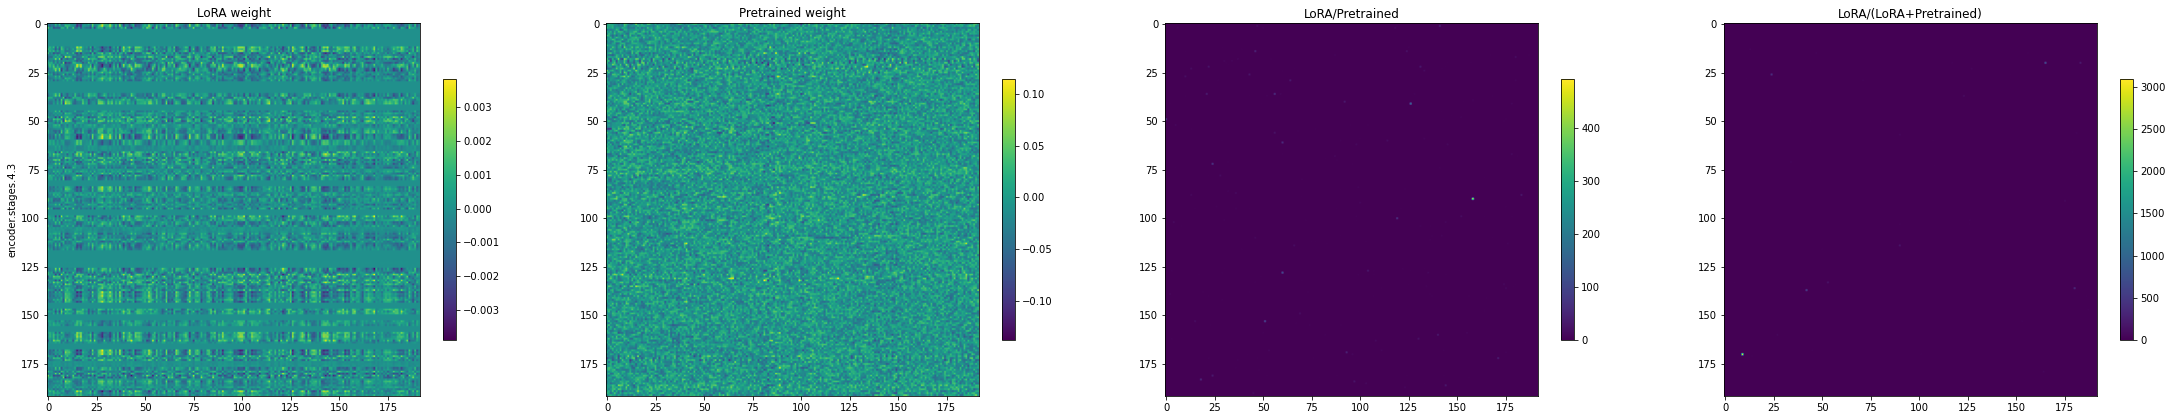

In [25]:
# pixel difference
for layer in list_lora_layer:
    add = (lora[layer+'.lora_B'] @ lora[layer+'.lora_A']).cpu().detach().numpy()
    pre = pretrained[layer+'.weight'].cpu().detach().numpy().reshape(add.shape)
    ratio_p = np.abs(add / pre)
    ratio_b = np.abs(add / (pre + add))
    # plot 
    if layer == 'encoder.stages.0.0':
        fig, axes = plt.subplots(1, 4, figsize=(add.shape[1]/20*6, add.shape[0]/20)) 
    else:
        fig, axes = plt.subplots(1, 4, figsize=(add.shape[1]/20*4, add.shape[0]/20)) 
    im = axes[0].imshow(add)
    axes[0].set_title('LoRA weight')
    axes[0].set_ylabel(layer)
    plt.colorbar(im, ax=axes[0], shrink=0.5)
    im = axes[1].imshow(pre)
    axes[1].set_title('Pretrained weight')
    plt.colorbar(im, ax=axes[1], shrink=0.5)
    im = axes[2].imshow(ratio_p)
    axes[2].set_title('LoRA/Pretrained')
    plt.colorbar(im, ax=axes[2], shrink=0.5)
    im = axes[3].imshow(ratio_b)
    axes[3].set_title('LoRA/(LoRA+Pretrained)')
    plt.colorbar(im, ax=axes[3], shrink=0.5)